In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving processed_data_300k.csv to processed_data_300k.csv


In [ ]:
df = pd.read_csv('processed_data_300k.csv')

In [ ]:
# Đọc file CSV
df = pd.read_csv('processed_data_300k.csv')

# Hàm mã hóa và padding
def encode_actions(X, y, max_len_MAX_SEQ_LEN):
    action2id = {"click": 0, "detail": 1, "purchase": 2, "add": 3, "remove": 4}
    pad_token = -1
    X_encoded = []
    for seq in X:
        actions = seq.split('.')
        encoded = [action2id.get(action, pad_token) for action in actions]
        if len(encoded) < max_len_MAX_SEQ_LEN:
            encoded += [pad_token] * (max_len_MAX_SEQ_LEN - len(encoded))
        else:
            encoded = encoded[:max_len_MAX_SEQ_LEN]
        X_encoded.append(encoded)
    X_encoded = np.array(X_encoded)
    print("Mã hóa và padding hàng với:", action2id)
    return X_encoded

# Thiết lập độ dài tối đa (điều chỉnh theo dữ liệu thực tế)
max_len_MAX_SEQ_LEN = 20  # Kiểm tra max(len(x.split('.')) for x in df['X']) để xác định
X = df['X'].values
X_encoded = encode_actions(X, df['y'].values, max_len_MAX_SEQ_LEN)
y = df['y'].values

# Kiểm tra nhãn
print("Giá trị duy nhất trong y:", np.unique(y))
num_classes = len(np.unique(y))  # Sẽ là 3 (0, 3, 4)

# Reshape dữ liệu cho GRU
X_reshaped = X_encoded.reshape((X_encoded.shape[0], X_encoded.shape[1], 1))
print("Kích thước X sau reshape:", X_reshaped.shape)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

Mã hóa và padding hàng với: {'click': 0, 'detail': 1, 'purchase': 2, 'add': 3, 'remove': 4}
Giá trị duy nhất trong y: [0 3 4]
Kích thước X sau reshape: (300000, 20, 1)


In [ ]:
# Kiểm tra nhãn
print("Giá trị duy nhất trong y:", np.unique(y))

# Mã hóa nhãn để chỉ chứa giá trị từ 0 đến num_classes - 1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Ánh xạ 0 -> 0, 3 -> 1, 4 -> 2 (tùy thứ tự xuất hiện)
print("Giá trị duy nhất sau khi mã hóa:", np.unique(y_encoded))

# Cập nhật y cho tập huấn luyện và kiểm tra
y_train, y_test = train_test_split(y_encoded, test_size=0.2, random_state=42)
num_classes = len(np.unique(y_encoded))  # Cập nhật số lớp

Giá trị duy nhất trong y: [0 3 4]
Giá trị duy nhất sau khi mã hóa: [0 1 2]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking

# Xây dựng mô hình
model = Sequential([
    Masking(mask_value=-1, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Biên dịch mô hình
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tóm tắt mô hình
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 20, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,851 (89.26 KB)

 Trainable params: 22,851 (89.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 90s 56ms/step - accuracy: 0.8769 - loss: 0.8258 - val_accuracy: 0.8847 - val_loss: 0.4688
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 145s 59ms/step - accuracy: 0.8832 - loss: 0.4573 - val_accuracy: 0.8847 - val_loss: 0.4379
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 147s 62ms/step - accuracy: 0.8830 - loss: 0.4421 - val_accuracy: 0.8847 - val_loss: 0.4375
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 139s 60ms/step - accuracy: 0.8829 - loss: 0.4422 - val_accuracy: 0.8847 - val_loss: 0.4375
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 86s 58ms/step - accuracy: 0.8824 - loss: 0.4436 - val_accuracy: 0.8847 - val_loss: 0.4375
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 88s 59ms/step - accuracy: 0.8817 - loss: 0.4454 - val_accuracy: 0.8847 - val_loss: 0.4374
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 141s 58ms/step - accuracy: 0.8823 - loss: 0.4438 - val_accuracy: 0.8847 - val_loss: 0.4375
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 84s 56ms/step - accuracy: 0.88

In [ ]:
# Đánh giá mô hình
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Độ chính xác trên tập kiểm tra: {test_accuracy:.4f}")
print(f"Loss trên tập kiểm tra: {test_loss:.4f}")

Độ chính xác trên tập kiểm tra: 0.8849
Loss trên tập kiểm tra: 0.4368


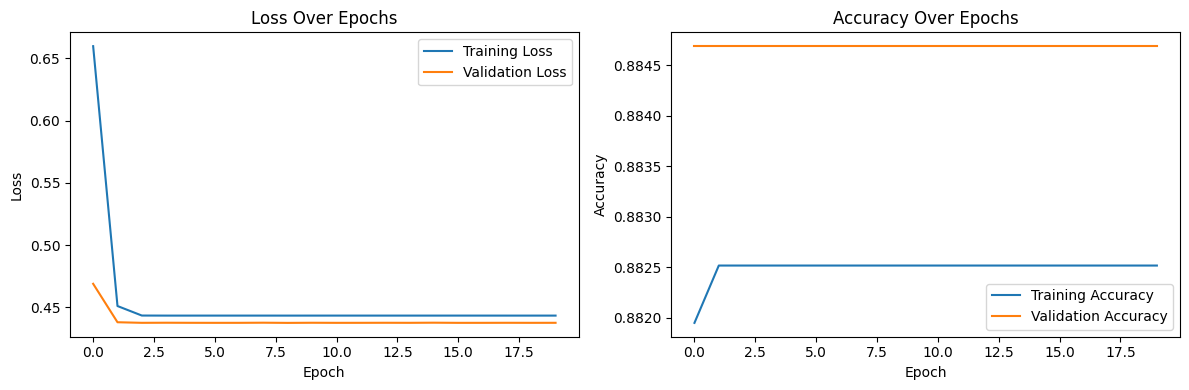

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(12, 4))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# In báo cáo phân loại
print("Báo cáo phân loại:\n", classification_report(y_test, y_pred_classes))

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3522
           1       0.88      1.00      0.94     53096
           2       0.00      0.00      0.00      3382

    accuracy                           0.88     60000
   macro avg       0.29      0.33      0.31     60000
weighted avg       0.78      0.88      0.83     60000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Lưu mô hình dưới dạng file .h5
model.save('gru_model_300k.h5')
print("Mô hình đã được lưu thành công dưới dạng gru_model_300k.h5")

Mô hình đã được lưu thành công dưới dạng gru_model_300k.h5


In [ ]:
from google.colab import files
files.download('gru_model_300k.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chuyển từ xác suất sang nhãn lớp (0, 1, 2)

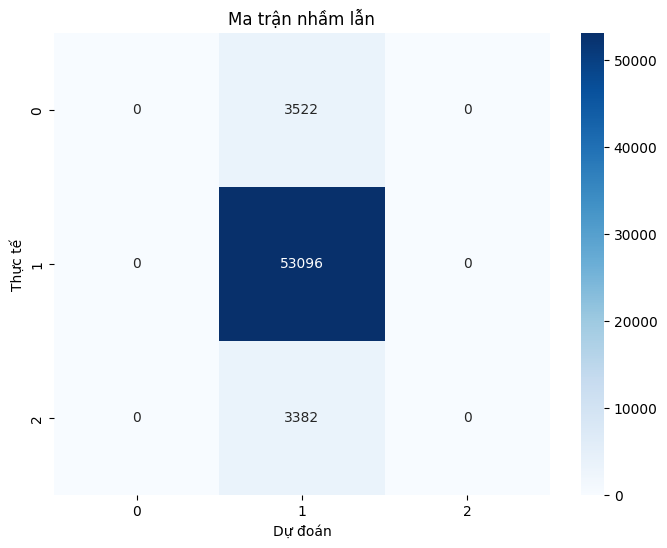

In [ ]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Ma trận nhầm lẫn')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [ ]:
#chuản bị dữ liệu dự đoán f1
import numpy as np
from sklearn.metrics import f1_score

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chuyển từ xác suất sang nhãn (0, 1, 2)

In [ ]:
# Tính F1-score
f1_macro = f1_score(y_test, y_pred_classes, average='macro')  # Trung bình macro
f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')  # Trung bình weighted

print(f"F1-score (macro): {f1_macro:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")

F1-score (macro): 0.3130
F1-score (weighted): 0.8309


In [ ]:
# Một dòng input thử nghiệm
sample = X_test[0].reshape(1, X_test.shape[1], X_test.shape[2])  # (1, time_steps, features)

pred = model.predict(sample)

print("Input mẫu:")
print(X_test[0])
print("Kết quả dự đoán:")
print(pred)
# Dự đoán trên tập test
preds = model.predict(X_test)

# In kết quả ra 5 dòng đầu
print("Kết quả dự đoán (5 dòng đầu):")
print(preds[:5])

# (Tùy) So sánh với nhãn thật
print("Nhãn thực tế:")
print(y_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Input mẫu:
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]]
Kết quả dự đoán:
[[0.06093664 0.8832602  0.05580315]]
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step
Kết quả dự đoán (5 dòng đầu):
[[0.06093664 0.88326013 0.05580314]
 [0.06093664 0.88326013 0.05580314]
 [0.06093664 0.88326013 0.05580314]
 [0.06093664 0.88326013 0.05580314]
 [0.06093664 0.88326013 0.05580314]]
Nhãn thực tế:
[1 2 1 2 0]
